# USTG

In [1]:
!pip -q install selfies
!pip -q install rdkit

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
import pandas as pd
import selfies as sf
import re


## Data Preparation

In [3]:
import pandas as pd

pd.options.mode.chained_assignment = None

SMILESdb = pd.read_csv('sample_db_only_smiles.csv')
print(SMILESdb.shape)
SMILESdb.head()

def encode_smiles(smiles):
    try:
        return sf.encoder(smiles)
    except Exception as e:
        return ''

SMILESdb['smiles'] = SMILESdb['smiles'].apply(encode_smiles)

SMILES = SMILESdb[SMILESdb['smiles'] != '']

SMILES['smiles'].to_csv('sample.txt', index=False)

bag_of_chem = ''.join(['[^]' + smiles for smiles in SMILESdb['smiles']])
print(bag_of_chem[:50])

(29547, 3)
[^][In][Branch2][Ring1][=C][C][Branch1][=Branch2][


## Tokenization

In [4]:
from tokenizer import Tokenizer

t = Tokenizer(bag_of_chem)

t.train_bpe(bag_of_chem, 4)

loaded_vocab = t.load()
testy = t.encode('[^][In][Branch2][Ring1][=C][C][Branch1][=Branch2][Si][Branch1][C][C][Branch1][C][C][C][Branch1][=Branch2][Si]', loaded_vocab)

print(t.decode(testy, loaded_vocab))

Iteration: 1, most often pair: [C][=C], occurs 197636 times, length of all tokenized data set: 2004504
Iteration: 2, most often pair: [C][C], occurs 181151 times, length of all tokenized data set: 1806868
Iteration: 3, most often pair: [C][=C][C][=C], occurs 86732 times, length of all tokenized data set: 1688682
Iteration: 4, most often pair: [Branch1][C][C], occurs 65978 times, length of all tokenized data set: 1633669
[^][In][Branch2][Ring1][=C][C][Branch1][=Branch2][Si][Branch1][C][C][Branch1][C][C][C][Branch1][=Branch2][Si]


## Architecture

## Training

In [5]:
#conventional training loop

from transformer import *
data = torch.tensor(t.encode(bag_of_chem, loaded_vocab))

train_test_split = 0.9
train_data = data[:int(train_test_split*len(data))]
valid_data = data[int(train_test_split*len(data)):]


#conventional training loop
model = TransformerLanguageModel()
model = model.to(DEVICE)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
best_val_loss = 10

for step in range(MAX_ITERS):

    if step % EVAL_ITERS == 0 or step == MAX_ITERS-1:
        losses = estimate_loss(model, train_data, valid_data)
        print('Step:',step,'Training Loss:',losses['train'],'Validation Loss:',losses['valid'])

    xb,yb = get_batch('train', train_data, valid_data, BATCH_SIZE, CONTEXT_LEN)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

context = torch.zeros((1,1), dtype=torch.long, device=DEVICE)

NameError: name 'train_data' is not defined

In [ ]:
new_structure = model.generate(context,max_new_tokens=200)[0].tolist()
new_structure_decode = t.decode(new_structure, loaded_vocab).split('[^]')

for ch in new_structure_decode:
  print(ch)

[Branch1][C][C][CH0]
[W@@][#PH0]







[FeH1][Ring2][C][SiH1][Fe]




[Fe][Branch1][Ring2][Ring1][Branch1][=Branch2][Branch2][Ring2][=N][PH0][=C][Ring1][=Branch1]

[Pt][CH1]

[CH2][#Branch1][Branch1][#Branch1][=Co][N][Branch1].[Cl]
[OsH1][OH0][CH0][OH0]
[Pt][Branch1][Fe][Branch1][=C][C][=Branch1][=N][CH1][Branch1][=Branch2][C][=C][Ring1][=Branch1][#Branch2][Re][CH0][Branch1][Branch2]
[=C][C][=C][C][=C][Ring1][=Branch2][Ring2][Branch1][Branch1][C][=Branch1][PH0][Ring2][C][=C][C][C][=C][Ring1][Branch1][C][=C][Ring1][=Branch1][C][=C][Ring1][#Branch1][=C][C][=C][Branch1][#Branch1][Branch1][=Branch1][CH0][CH0][Branch1][=Branch2][C][Ring1][=Branch2][C][=C][/CH1]
[Cl].[=Branch2][C][=C][C][#C][Cl]

[Fe][Branch1][#Branch2][C][Cl][Branch2][Ring2]
[S][Branch1][=Branch2][N][Branch1][=Branch2][Cl][Branch1][#Branch1][C][=C][Branch1][=Branch2][C][N][Ring1][=Branch2][Branch2][Ring2][Ge][Branch2][Ring2][Ring2][Ring1][#Branch1][O][Ring1][#Branch1][Branch1][C]
[Ti@@][N][#Branch1][C][=Branch1][=Branch2][

## Results

In [ ]:
output_smi = []
for el in new_structure_decode:
  output_smi.append(sf.decoder(el))
output_smi

['CC[CH0]',
 '[W@@]#[PH0]',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '[FeH1][Fe]',
 '',
 '',
 '',
 '',
 '[Fe]1[PH0]=C1',
 '',
 '[Pt][CH1]',
 '',
 '[CH2][Co]N.Cl',
 '[OsH1][OH0][CH0][OH0]',
 '[Pt]1=CC[CH1]C=C1[Re][CH0]',
 'C=1C=CC=C=1',
 'Cl.C=CC#CCl',
 '',
 '[Fe]CCl',
 'S(NCl)#N',
 '[Ti@@]1NN1',
 'P=[CH1][CH0][OH0]',
 '[CH0][OH0]CC=C']

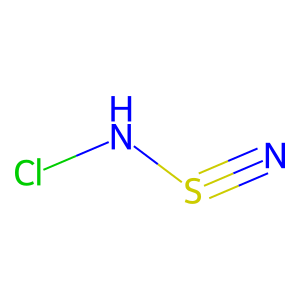

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

import numpy as np

m = Chem.MolFromSmiles(output_smi[-4])
img = Draw.MolToImage(m)
img